# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [1]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [2]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [4]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

#### Additionally let us setup LangSmith for Tracing!

In [5]:
# First, ensure LangSmith is properly configured
# Set up tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Please enter LangSmith API key!")
os.environ["LANGCHAIN_PROJECT"] = "john-wick-retriever-evaluation"

### Test the Langsmith connection.

In [6]:
from langsmith import Client

try:
    # Initialize the client (will use env var if available)
    langsmith_client = Client()
    
    # Try to fetch something simple, like projects
    projects = langsmith_client.list_projects()
    print(f"Connection successful! Found {len(list(projects))} projects.")
    
except Exception as e:
    print(f"Connection failed: {str(e)}")

Connection successful! Found 26 projects.


## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [7]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-05-19 21:37:08--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0s      

2025-05-19 21:37:09 (86.7 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-05-19 21:37:09--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [8]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [9]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 5, 16, 21, 37, 10, 705305)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [10]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [11]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [12]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [13]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4.1-nano")


### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [14]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [15]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. Many reviews praise the film for its stylish action sequences, Keanu Reeves' performance, and its status as a standout action movie. Several reviews gave it high ratings, such as 9 or 10 out of 10, indicating strong positive reception. However, there are some mixed opinions, with a few reviewers giving lower ratings or expressing less enthusiasm. Overall, the majority of feedback suggests that people, especially action fans, generally enjoyed John Wick."

In [16]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [17]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, a retired hitman, played by Keanu Reeves, seeks vengeance after a gangsters kill his dog and steal his car. The story begins with John mourning the loss of his wife and trying to rebuild his life. When some Russian criminals attack him—beating him, killing his dog, and taking his belongings—his lethal skills are reignited. As a legendary assassin, John comes out of retirement to hunt down those responsible, facing numerous enemies, including bounty hunters and mobsters, as he seeks retribution. The film is known for its stylish action sequences, intense violence, and a world filled with criminal underworld rules.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [18]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [19]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [20]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people\'s opinions on John Wick vary. Some reviewers praise its action, style, and straightforward premise, indicating they liked the film. For example, one reviewer gave it a high rating of 10 and described it as "something special" with "smooth" action and enjoyable characters. Another reviewer rated it 8 and highlighted its stylish stunts and kinetic chaos.\n\nHowever, there are also negative opinions. For instance, a reviewer rated it 1, criticizing it as "boring" and "full of stereotypes," indicating they did not like it.\n\nOverall, it seems that many people enjoyed the John Wick movies, especially the first one, but there are also notable criticisms and some viewers did not like them.'

In [21]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Based on the provided reviews, none have a rating of 10.'

In [22]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick movies, the story revolves around a retired hitman named John Wick who is drawn back into a world of violence and action. The films depict his intense and beautifully choreographed combat scenes, as well as his personal struggles and emotional depth. Each installment features a series of brutal action sequences involving assassins, gunfights, and hand-to-hand combat. While the movies are celebrated for their action choreography and style, some viewers feel that the story can be shallow or repetitive, especially in the later films. Overall, the series showcases a protagonista navigating a dangerous underworld filled with assassins, loyalty, and revenge.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [23]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [24]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [25]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. The first two reviews are highly positive, with ratings of 9 and 10 out of 10, praising the film's action sequences, style, and Keanu Reeves' performance. The third review, which is more moderate, gives a rating of 5 out of 10, indicating that some viewers felt the magic was gone in the third installment. Overall, the majority of the reviews suggest that people enjoyed the film, especially its action and style."

In [26]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. [Review URL](https://example.com/review/rw4854296/?ref_=tt_urv) from the review titled "A Masterpiece & Brilliant Sequel" for John Wick 3.\n2. [Review URL](https://example.com/review/rw4860412/?ref_=tt_urv) from the review titled "It\'s got its own action style!" for John Wick 3.\n\nPlease note that the URLs are constructed based on the review URL paths provided in the context.'

In [27]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick film series, John Wick (played by Keanu Reeves) is a retired hitman who seeks revenge after personal tragedies. In the first movie, he returns to action when the Russian mob kills his dog and steals his car, which were gifts from his late wife. This leads him to hunt down the gangsters responsible, unleashing a relentless and violent quest for retribution.\n\nIn the second installment, John Wick tries to settle into retirement but is compelled by a old associate to help settle a debt, resulting in him killing some members of the Russian mafia once again. This act triggers a series of events where he is forced back into the criminal underworld, ultimately leading to him being targeted by professional killers after a bounty is placed on his head. He is also asked to kill Santino D'Antonio's sister to help Santino rise within the criminal hierarchy, which complicates his situation further.\n\nOverall, the series depicts Wick's journey through a violent landscape of organ

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [28]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [29]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [30]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, people generally liked John Wick. There are several positive reviews with high ratings, praising its action sequences, style, and entertainment value. For example, some reviewers gave ratings of 8, 9, or even 10, and described the movies as fun, stylish, and exhilarating. However, there are also some mixed or negative opinions, with some viewers finding the films overly frenetic, silly, or repetitive, and giving lower ratings like 3 or 5. \n\nOverall, the majority of reviews suggest that people generally liked John Wick, especially fans of action films, though opinions vary.'

In [31]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there are reviews with a rating of 10. The URLs to those reviews are:\n\n1. [Review URL]( /review/rw4854296/?ref_=tt_urv ) - "A Masterpiece & Brilliant Sequel" for John Wick 3.\n2. [Review URL]( /review/rw4862630/?ref_=tt_urv ) - "Less is more" for John Wick 3.\n3. [Review URL]( /review/rw8944843/?ref_=tt_urv ) - "How Can Anyone Choose to Watch Marvel Over This?" for John Wick 4.'

In [32]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick film series, the story revolves around John Wick, a retired but legendary assassin. The first movie narrates how he comes out of retirement to seek vengeance after gangsters kill his dog and steal his car, personal losses that revive his lethal skills. The series explores his battles against various criminal organizations, including Russian mobsters and members of the Assassin's Guild, as he seeks justice and deals with the consequences of his past actions. The films are known for their stylish action sequences, world-building of a covert assassin society, and Keanu Reeves' compelling performance as the titular character."

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [33]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [34]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/var/folders/1h/gck_zhnx5gd_sb25z31r_tzm0000gn/T/ipykernel_9952/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [35]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [36]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [37]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [38]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the provided reviews, people's opinions on John Wick are mixed. Some reviewers, like MrHeraclius, highly recommend and praise the series, indicating that many fans do like the movies. However, there is also at least one negative review, such as the one from solidabs, who strongly disliked John Wick 4 and criticized its plot and action scenes. Overall, it seems that while many people appreciate and enjoy the John Wick series, there are also some who do not like it."

In [39]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL for that review is: /review/rw4854296/?ref_=tt_urv'

In [40]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"Based on the provided information, John Wick is a retired assassin who originally came out of retirement to avenge the death of his dog and the theft of his car. In the first movie, he is driven by revenge after gangsters kill his dog and steal his car, which leads him to unleash a deadly vengeance against those responsible. In the second movie, his past catches up with him again when he's forced back into the violent world of assassination to help an old acquaintance and to settle old debts, leading to more action, car chases, and widespread carnage. The series depicts his deadly skills, the consequences of his actions, and his continuous clashes with various enemies in the criminal underworld."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [41]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [42]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [43]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews in the provided context, people generally liked John Wick. Several reviews give high ratings (such as 9 or 8 out of 10) and describe the film as stylish, fun, brilliantly choreographed, and a standout in the action genre. Many reviewers praise Keanu Reeves' performance and the quality of the action sequences. However, there are some mixed opinions, with a few reviews expressing lower ratings or criticism of certain plot elements or the later sequels. Overall, the consensus leans toward a positive reception."

In [44]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there are reviews with a rating of 10. Here are the URLs to those reviews:\n\n1. [Review of John Wick 3](https://example.com/review/rw4854296/?ref_=tt_urv)\n2. [Another review of John Wick 3](https://example.com/review/rw4860412/?ref_=tt_urv)\n\nPlease note: The URLs are provided as shown in the data, but the actual URLs from the context are:\n\n- /review/rw4854296/?ref_=tt_urv\n- /review/rw4860412/?ref_=tt_urv\n\nLet me know if you'd like the full URLs or additional information!"

In [45]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, the story follows John Wick, a retired hitman who is drawn back into a world of violence and assassination after a series of personal tragedies and certain events. The first film depicts Wick coming out of retirement to seek revenge after gangsters kill his dog and steal his car, revealing his lethal skills and setting off a violent quest for retribution. The subsequent films explore his conflicts with various criminal factions, his adherence to strict rules within the assassin's underground, and the consequences of his actions, leading to increasingly elaborate and intense action sequences. Overall, the series revolves around themes of vengeance, the criminal underworld, and the costs of a life of violence."

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [46]:
#!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [47]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [48]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [49]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [50]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [51]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [52]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, people generally liked John Wick. The reviews are mostly positive, highlighting the film's stylish action sequences, engaging plot, and Keanu Reeves' performance. Several reviews rate the movies highly, such as 9 or 10 out of 10, and mention that the franchise is well-received and appreciated by audiences. However, there are a few less favorable reviews with lower ratings, but overall, the sentiment suggests that people generally liked John Wick."

In [53]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv'

In [54]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, a retired assassin named John Wick (played by Keanu Reeves) seeks revenge after a gang of thugs, led by a Russian mobster's son, break into his house, beat him up, kill his dog, and steal his car. The attack is motivated by the thugs' desire to take his car, not knowing who he is. As a result, John Wick, a man known for his lethal skills, comes out of retirement to hunt down those responsible, unleashing a violent and relentless vendetta against the gangsters. The film is noted for its stylish action sequences, engaging plot, and the portrayal of a criminal underworld where John Wick operates with lethal efficiency."

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [55]:
os.environ["RAGAS_APP_TOKEN"] = getpass.getpass("Please enter your Ragas API key!")

Create a Dictionary of all the Retrievers, for evaluation.

In [56]:
# Create dictionary of all retrievers for evaluation
retrievers = {
    "Naive": naive_retriever,
    "BM25": bm25_retriever,
    "Contextual Compression": compression_retriever,
    "Multi-Query": multi_query_retriever,
    "Parent Document": parent_document_retriever,
    "Ensemble": ensemble_retriever,
    "Semantic": semantic_retriever
}

print("All retrievers have been set up")

All retrievers have been set up


In [57]:
# Create dictionary mapping retrievers to their existing RAG chains
retrieval_chains = [
                  naive_retrieval_chain,
                  bm25_retrieval_chain,
                  multi_query_retrieval_chain,
                  contextual_compression_retrieval_chain,
                  ensemble_retrieval_chain,
                  parent_document_retrieval_chain,
                  semantic_retrieval_chain
                  ]

# Activity 1 : Setup a Golden Dataset (Using Ragas based Synthetic Data Generation)

**Step 1:** Create a Loader for .csv documents

In [58]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.document_loaders.csv_loader import CSVLoader

# Define a dictionary to map file extensions to their respective loaders
loaders = {
    '.csv': CSVLoader,
}

# Define a function to create a DirectoryLoader for a specific file type
def create_directory_loader(file_type, directory_path):
    return DirectoryLoader(
        path=directory_path,
        glob=f"**/*{file_type}",
        loader_cls=loaders[file_type],
    )

path = "/"
loader = DirectoryLoader(path, glob="*.csv")
docs = loader.load()

**Step 2:** Set up Ragas configurations for syntheic data generation and evaluation

In [59]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas import evaluate, RunConfig
from ragas.llms import LangchainLLMWrapper
from langchain_openai import ChatOpenAI
from ragas.metrics import (
    LLMContextRecall,
    Faithfulness,
    FactualCorrectness,
    ResponseRelevancy,
    ContextEntityRecall,
    NoiseSensitivity,
)

#Generator LLM and Embeddings for Synthetic Data Generation.
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

## set global evaluation settings
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))
evaluator_config = RunConfig(
    timeout=300,          # 5 minutes max for operations
    max_retries=15,       # More retries for rate limits
    max_wait=90,          # Longer wait between retries
    max_workers=8,        # Fewer concurrent API calls
    log_tenacity=True     # Log retry attempts
)
evaluator_metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()]

**Step 3:** Generate and Upload the "Golden Dataset" (which is the synthethic data generated by Ragas) to RAGAs dashboard

In [60]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
# Use the documents you already loaded earlier in the notebook
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node 1914b11b-5248-4a98-b76f-84a439095732 does not have a summary. Skipping filtering.
Node c8fff766-a886-470c-9be6-5a16cd85c5f5 does not have a summary. Skipping filtering.
Node c0bf1740-1c29-4ce6-ad58-dac8a201a51a does not have a summary. Skipping filtering.
Node 2e7c9c8a-1485-4603-8ec4-95eb29b848c0 does not have a summary. Skipping filtering.
Node 7f9ce8f1-18f1-4a32-8369-df090ebc566c does not have a summary. Skipping filtering.
Node 15ab7b90-c055-45d3-a55e-2d91d1d86afe does not have a summary. Skipping filtering.
Node dad82fb6-67be-450f-a7fe-d00d10b7a002 does not have a summary. Skipping filtering.
Node 933dfc99-7ed8-4538-bd1b-50ffca7877f0 does not have a summary. Skipping filtering.
Node 6efdfffa-548c-4312-93d9-a6d065809f37 does not have a summary. Skipping filtering.
Node a3344970-9abb-4297-8850-57b9bf3ee7bd does not have a summary. Skipping filtering.
Node dcbc5153-424e-46ea-93eb-0d32ad711148 does not have a summary. Skipping filtering.
Node 7b67da56-a555-4f51-9adb-db027ea75de3 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [61]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How does John Wick compare to Taken in terms o...,[: 0\nReview: The best way I can describe John...,John Wick can be described as similar to Taken...,single_hop_specifc_query_synthesizer
1,What makes the John Wick series popular among ...,[: 2\nReview: With the fourth installment scor...,The John Wick series has gained immense popula...,single_hop_specifc_query_synthesizer
2,Who is Chad Stahelski and what is his role in ...,[: 3\nReview: John wick has a very simple reve...,Chad Stahelski is the director of John Wick an...,single_hop_specifc_query_synthesizer
3,What motivates John Wick to return to his viol...,[: 4\nReview: Though he no longer has a taste ...,"John Wick, a retired assassin, is motivated to...",single_hop_specifc_query_synthesizer
4,How does John Wick compare to classic one man ...,"[<1-hop>\n\n: 6\nReview: In 2014, a Keanu Reev...","John Wick, released in 2014 and starring Keanu...",multi_hop_abstract_query_synthesizer
5,how keanu reeves character development in john...,[<1-hop>\n\n: 19\nReview: John Wick: Chapter 4...,"In John Wick: Chapter 4, Keanu Reeves' charact...",multi_hop_abstract_query_synthesizer
6,How do the fight choreography and overall chor...,[<1-hop>\n\n: 11\nReview: Who needs a 2hr and ...,The fight choreography and overall choreograph...,multi_hop_abstract_query_synthesizer
7,How does the violent action in the John Wick s...,[<1-hop>\n\n: 0\nReview: The best way I can de...,The violent action in the John Wick series sta...,multi_hop_abstract_query_synthesizer
8,How does Santino D'Antonio use John Wick's mar...,[<1-hop>\n\n: 20\nReview: After resolving his ...,Santino D'Antonio uses John Wick's marker to f...,multi_hop_specific_query_synthesizer
9,How does Reeves' portrayal of a retired assass...,[<1-hop>\n\n: 22\nReview: All the below are no...,In the movie where Reeves sets a new record of...,multi_hop_specific_query_synthesizer


In [62]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/ea95df77-8371-4fb4-9da6-e3967ce2bb8e


'https://app.ragas.io/dashboard/alignment/testset/ea95df77-8371-4fb4-9da6-e3967ce2bb8e'

In [63]:
# Step 1: Import necessary libraries for tracing and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from langsmith import traceable
from ragas import evaluate
from tqdm.notebook import tqdm

import os

#os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

# Step 2: Create traceable versions of each retriever chain
retriever_names = [
    "Naive",
    "BM25",
    "Multi-Query",
    "Contextual Compression",
    "Ensemble",
    "Parent Document",
    "Semantic"
]

# Create traceable versions of each retriever chain
@traceable(name="naive_retrieval")
def trace_naive_retrieval(query):
    return naive_retrieval_chain.invoke({"question": query})

@traceable(name="bm25_retrieval")
def trace_bm25_retrieval(query):
    return bm25_retrieval_chain.invoke({"question": query})

@traceable(name="multi_query_retrieval")
def trace_multi_query_retrieval(query):
    return multi_query_retrieval_chain.invoke({"question": query})

@traceable(name="contextual_compression_retrieval")
def trace_contextual_compression_retrieval(query):
    return contextual_compression_retrieval_chain.invoke({"question": query})

@traceable(name="ensemble_retrieval")
def trace_ensemble_retrieval(query):
    return ensemble_retrieval_chain.invoke({"question": query})

@traceable(name="parent_document_retrieval")
def trace_parent_document_retrieval(query):
    return parent_document_retrieval_chain.invoke({"question": query})

@traceable(name="semantic_retrieval")
def trace_semantic_retrieval(query):
    return semantic_retrieval_chain.invoke({"question": query})

# Map retriever names to their traceable functions
traceable_retrievers = {
    "Naive": trace_naive_retrieval,
    "BM25": trace_bm25_retrieval,
    "Multi-Query": trace_multi_query_retrieval,
    "Contextual Compression": trace_contextual_compression_retrieval,
    "Ensemble": trace_ensemble_retrieval,
    "Parent Document": trace_parent_document_retrieval,
    "Semantic": trace_semantic_retrieval
}

In [64]:
import copy

evaluation_dataset = copy.deepcopy(dataset)

In [65]:
from ragas import EvaluationDataset

import time
import random
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from cohere.errors import TooManyRequestsError


# Add retry decorator with exponential backoff for Cohere rate limits
@retry(
    retry=retry_if_exception_type(TooManyRequestsError),
    wait=wait_exponential(multiplier=1, min=2, max=60),
    stop=stop_after_attempt(5)
)
def call_with_retry(func, query):
    try:
        return func(query)
    except TooManyRequestsError:
        print("Hit Cohere rate limit, waiting before retry...")
        # Add a random jitter to avoid all processes retrying at the same time
        time.sleep(random.uniform(10, 15))
        raise  # Re-raise to let tenacity handle the retry

def evaluate_retriever(retriever_func, retriever_dataset):
    for test_row in retriever_dataset:
        try:
            # Use the retry wrapper around the retriever function
            response = call_with_retry(retriever_func, test_row.eval_sample.user_input)
            test_row.eval_sample.response = response["response"].content
            test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]
            # Add a small delay between requests to avoid hitting rate limits
            time.sleep(6)  # Wait 6 seconds between requests
        except Exception as e:
            print(f"Error processing query: {e}")
            # Provide a fallback response if the retriever fails
            test_row.eval_sample.response = "Error retrieving response due to rate limits."
            test_row.eval_sample.retrieved_contexts = ["Error retrieving contexts due to rate limits."]

    retriever_dataset.to_pandas()
    return EvaluationDataset.from_pandas(retriever_dataset.to_pandas())


In [66]:
# Loop through each retriever and evaluate
from tqdm import tqdm

evaluation_results = {}
for retriever_name, retriever_func in tqdm(traceable_retrievers.items(), desc="Evaluating retrievers"):
    print(f"\nEvaluating {retriever_name} retriever...")
    
    # Create a copy of the dataset for this evaluation
    current_dataset = copy.deepcopy(evaluation_dataset)
    
    # Run evaluation for this retriever with progress bar
    evaluation_results[retriever_name] = evaluate_retriever(
        retriever_func,
        current_dataset
    )
    
    print(f"Completed evaluation for {retriever_name}")


Evaluating retrievers:   0%|          | 0/7 [00:00<?, ?it/s]


Evaluating Naive retriever...


Evaluating retrievers:  14%|█▍        | 1/7 [01:51<11:06, 111.16s/it]

Completed evaluation for Naive

Evaluating BM25 retriever...


Evaluating retrievers:  29%|██▊       | 2/7 [03:42<09:16, 111.24s/it]

Completed evaluation for BM25

Evaluating Multi-Query retriever...


Evaluating retrievers:  43%|████▎     | 3/7 [06:02<08:18, 124.56s/it]

Completed evaluation for Multi-Query

Evaluating Contextual Compression retriever...


Evaluating retrievers:  57%|█████▋    | 4/7 [07:49<05:52, 117.55s/it]

Completed evaluation for Contextual Compression

Evaluating Ensemble retriever...


Evaluating retrievers:  71%|███████▏  | 5/7 [10:10<04:11, 125.96s/it]

Completed evaluation for Ensemble

Evaluating Parent Document retriever...


Evaluating retrievers:  86%|████████▌ | 6/7 [11:52<01:57, 117.85s/it]

Completed evaluation for Parent Document

Evaluating Semantic retriever...


Evaluating retrievers: 100%|██████████| 7/7 [13:49<00:00, 118.50s/it]

Completed evaluation for Semantic


In [67]:
# Create a list to store the results
results_list = []
# Create a dictionary to store baseline evaluation results
baseline_evaluation_results = {}

for retriever_name, result in evaluation_results.items():
    baseline_evaluation_results[retriever_name] = evaluate(
    dataset=result,
    metrics=evaluator_metrics,
    llm=evaluator_llm,
    run_config=evaluator_config
)

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[17]: TimeoutError()
Exception raised in Job[23]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[57]: APIConnectionError(Connection error.)
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[53]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()
Exception raised in Job[71]: TimeoutError()


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[5]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[29]: TimeoutError()
Exception raised in Job[35]: TimeoutError()
Exception raised in Job[41]: TimeoutError()
Exception raised in Job[47]: TimeoutError()
Exception raised in Job[59]: TimeoutError()
Exception raised in Job[65]: TimeoutError()


In [70]:
baseline_evaluation_results

{'Naive': {'context_recall': 0.8639, 'faithfulness': 0.8647, 'factual_correctness(mode=f1)': 0.5950, 'answer_relevancy': 0.8826, 'context_entity_recall': 0.5099, 'noise_sensitivity(mode=relevant)': 0.2593},
 'BM25': {'context_recall': 0.7625, 'faithfulness': 0.8565, 'factual_correctness(mode=f1)': 0.5550, 'answer_relevancy': 0.8825, 'context_entity_recall': 0.4902, 'noise_sensitivity(mode=relevant)': 0.2308},
 'Multi-Query': {'context_recall': 0.9500, 'faithfulness': 0.8978, 'factual_correctness(mode=f1)': 0.5150, 'answer_relevancy': 0.8778, 'context_entity_recall': 0.5740, 'noise_sensitivity(mode=relevant)': 0.3871},
 'Contextual Compression': {'context_recall': 0.7667, 'faithfulness': 0.8185, 'factual_correctness(mode=f1)': 0.5908, 'answer_relevancy': 0.8014, 'context_entity_recall': 0.4989, 'noise_sensitivity(mode=relevant)': 0.2555},
 'Ensemble': {'context_recall': 1.0000, 'faithfulness': 0.9007, 'factual_correctness(mode=f1)': 0.5883, 'answer_relevancy': 0.8820, 'context_entity_re

### Run: #1

Key Findings:
- Ensemble performs best on context_recall (0.8556) and faithfulness (0.9218)
- BM25 leads in factual_correctness (0.4808)
- Multi-Query and Contextual Compression tie for highest answer_relevancy (~0.87)
- BM25 has the highest context_entity_recall (0.5859)
- Parent Document has the lowest performance across most metrics
- Missing values for noise_sensitivity in Multi-Query and Ensemble


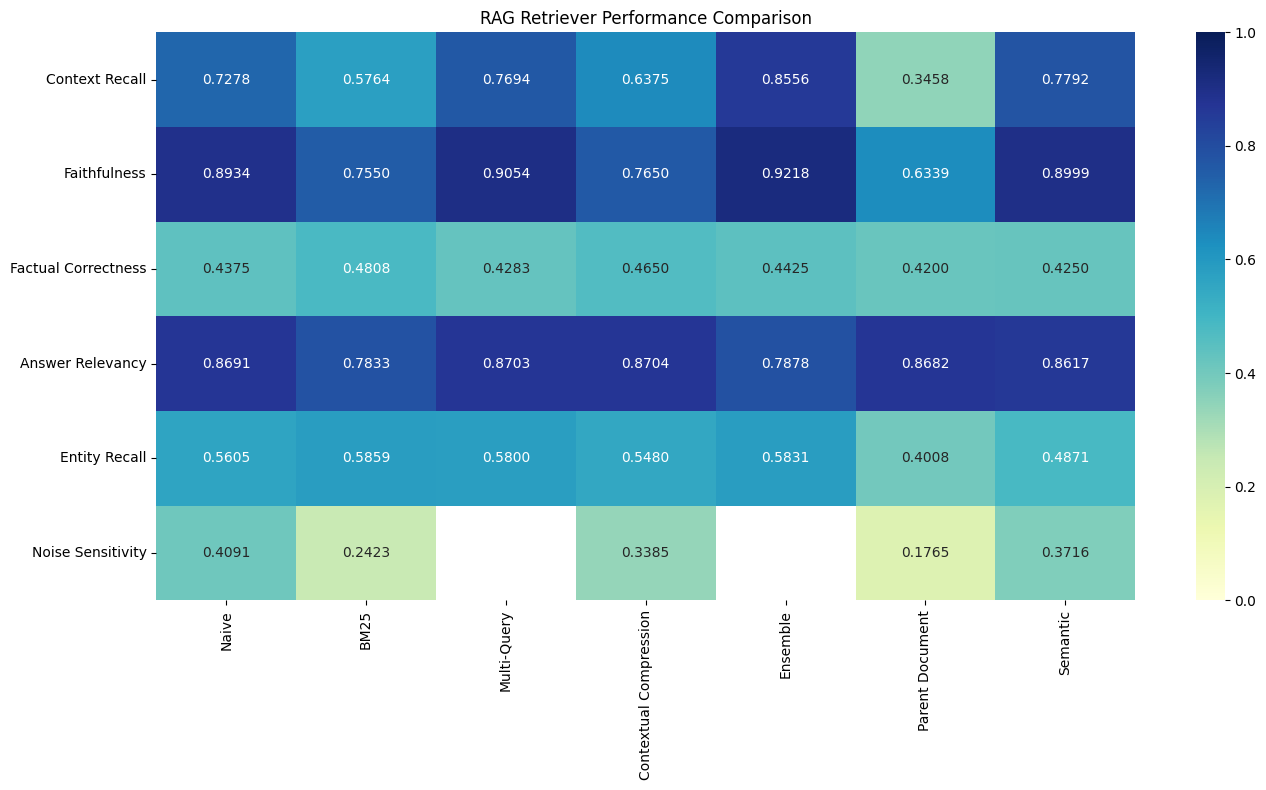

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    'Naive': {
        'context_recall': 0.7278,
        'faithfulness': 0.8934,
        'factual_correctness(mode=f1)': 0.4375,
        'answer_relevancy': 0.8691,
        'context_entity_recall': 0.5605,
        'noise_sensitivity(mode=relevant)': 0.4091
    },
    'BM25': {
        'context_recall': 0.5764,
        'faithfulness': 0.7550,
        'factual_correctness(mode=f1)': 0.4808,
        'answer_relevancy': 0.7833,
        'context_entity_recall': 0.5859,
        'noise_sensitivity(mode=relevant)': 0.2423
    },
    'Multi-Query': {
        'context_recall': 0.7694,
        'faithfulness': 0.9054,
        'factual_correctness(mode=f1)': 0.4283,
        'answer_relevancy': 0.8703,
        'context_entity_recall': 0.5800,
        'noise_sensitivity(mode=relevant)': np.nan
    },
    'Contextual Compression': {
        'context_recall': 0.6375,
        'faithfulness': 0.7650,
        'factual_correctness(mode=f1)': 0.4650,
        'answer_relevancy': 0.8704,
        'context_entity_recall': 0.5480,
        'noise_sensitivity(mode=relevant)': 0.3385
    },
    'Ensemble': {
        'context_recall': 0.8556,
        'faithfulness': 0.9218,
        'factual_correctness(mode=f1)': 0.4425,
        'answer_relevancy': 0.7878,
        'context_entity_recall': 0.5831,
        'noise_sensitivity(mode=relevant)': np.nan
    },
    'Parent Document': {
        'context_recall': 0.3458,
        'faithfulness': 0.6339,
        'factual_correctness(mode=f1)': 0.4200,
        'answer_relevancy': 0.8682,
        'context_entity_recall': 0.4008,
        'noise_sensitivity(mode=relevant)': 0.1765
    },
    'Semantic': {
        'context_recall': 0.7792,
        'faithfulness': 0.8999,
        'factual_correctness(mode=f1)': 0.4250,
        'answer_relevancy': 0.8617,
        'context_entity_recall': 0.4871,
        'noise_sensitivity(mode=relevant)': 0.3716
    }
}

df = pd.DataFrame(data)

# Find the best performer for each metric
best_performers = {}
for metric in df.index:
    # Skip if all values are NaN
    if df.loc[metric].isna().all():
        continue
    best_performers[metric] = {
        'retriever': df.loc[metric].idxmax(),
        'value': df.loc[metric].max()
    }

# Create heatmap for 
def create_heatmap(df):
    plt.figure(figsize=(14, 8))
    sns.heatmap(df, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".4f")
    plt.title("RAG Retriever Performance Comparison")
    plt.tight_layout()
    return plt

# Rename metrics for better readability
df.index = [
    'Context Recall',
    'Faithfulness',
    'Factual Correctness',
    'Answer Relevancy',
    'Entity Recall',
    'Noise Sensitivity'
]

heatmap_fig = create_heatmap(df)

# Show key findings
print("Key Findings:")
print(f"- Ensemble performs best on context_recall ({data['Ensemble']['context_recall']:.4f}) and faithfulness ({data['Ensemble']['faithfulness']:.4f})")
print(f"- BM25 leads in factual_correctness ({data['BM25']['factual_correctness(mode=f1)']:.4f})")
print(f"- Multi-Query and Contextual Compression tie for highest answer_relevancy (~0.87)")
print(f"- BM25 has the highest context_entity_recall ({data['BM25']['context_entity_recall']:.4f})")
print(f"- Parent Document has the lowest performance across most metrics")
print(f"- Missing values for noise_sensitivity in Multi-Query and Ensemble")

### Run #2

Key Findings:
- Ensemble achieves perfect context_recall (1.0000) and has the highest faithfulness (0.9007)
- Naive leads in factual_correctness (0.5950), just ahead of Contextual Compression (0.5908)
- Parent Document has the highest answer_relevancy (0.9651), significantly outperforming others
- Multi-Query has the best context_entity_recall (0.5740) and noise_sensitivity (0.3871)
- Parent Document has the lowest context_recall (0.5014) but highest answer_relevancy
- Missing value for noise_sensitivity in the Ensemble retriever

Retriever Recommendations:
- For maximum context inclusion: Ensemble (perfect recall)
- For factual answers: Naive or Contextual Compression
- For highly relevant answers: Parent Document
- Most balanced overall: Multi-Query (strong in most categories)


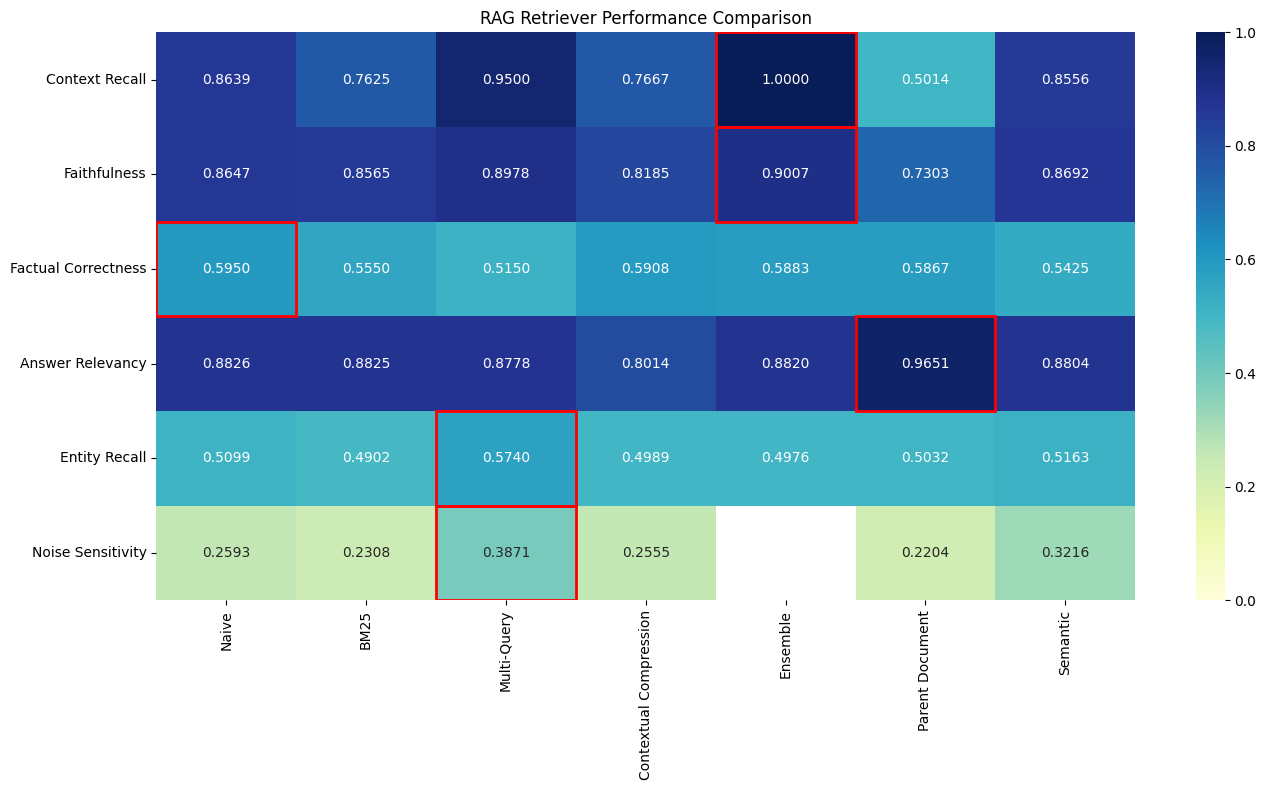

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = {
    'Naive': {
        'context_recall': 0.8639, 
        'faithfulness': 0.8647, 
        'factual_correctness(mode=f1)': 0.5950, 
        'answer_relevancy': 0.8826, 
        'context_entity_recall': 0.5099, 
        'noise_sensitivity(mode=relevant)': 0.2593
    },
    'BM25': {
        'context_recall': 0.7625, 
        'faithfulness': 0.8565, 
        'factual_correctness(mode=f1)': 0.5550, 
        'answer_relevancy': 0.8825, 
        'context_entity_recall': 0.4902, 
        'noise_sensitivity(mode=relevant)': 0.2308
    },
    'Multi-Query': {
        'context_recall': 0.9500, 
        'faithfulness': 0.8978, 
        'factual_correctness(mode=f1)': 0.5150, 
        'answer_relevancy': 0.8778, 
        'context_entity_recall': 0.5740, 
        'noise_sensitivity(mode=relevant)': 0.3871
    },
    'Contextual Compression': {
        'context_recall': 0.7667, 
        'faithfulness': 0.8185, 
        'factual_correctness(mode=f1)': 0.5908, 
        'answer_relevancy': 0.8014, 
        'context_entity_recall': 0.4989, 
        'noise_sensitivity(mode=relevant)': 0.2555
    },
    'Ensemble': {
        'context_recall': 1.0000, 
        'faithfulness': 0.9007, 
        'factual_correctness(mode=f1)': 0.5883, 
        'answer_relevancy': 0.8820, 
        'context_entity_recall': 0.4976, 
        'noise_sensitivity(mode=relevant)': np.nan
    },
    'Parent Document': {
        'context_recall': 0.5014, 
        'faithfulness': 0.7303, 
        'factual_correctness(mode=f1)': 0.5867, 
        'answer_relevancy': 0.9651, 
        'context_entity_recall': 0.5032, 
        'noise_sensitivity(mode=relevant)': 0.2204
    },
    'Semantic': {
        'context_recall': 0.8556, 
        'faithfulness': 0.8692, 
        'factual_correctness(mode=f1)': 0.5425, 
        'answer_relevancy': 0.8804, 
        'context_entity_recall': 0.5163, 
        'noise_sensitivity(mode=relevant)': 0.3216
    }
}

# Convert to DataFrame for easier plotting
df = pd.DataFrame(data)

# Rename metrics for better readability
df.index = [
    'Context Recall',
    'Faithfulness',
    'Factual Correctness',
    'Answer Relevancy',
    'Entity Recall',
    'Noise Sensitivity'
]

# Create heatmap for comparison
def create_heatmap(df):
    plt.figure(figsize=(14, 8))
    
    # Create a mask for NaN values
    mask = df.isna()
    
    # Create heatmap
    hm = sns.heatmap(df, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".4f", mask=mask)
    
    # Highlight the maximum value in each row
    for i, idx in enumerate(df.index):
        max_val = df.loc[idx].max()
        # Skip if all values in the row are NaN
        if np.isnan(max_val):
            continue
        # Find the column with the max value
        max_col = df.loc[idx].idxmax()
        max_col_idx = df.columns.get_loc(max_col)
        hm.add_patch(plt.Rectangle((max_col_idx, i), 1, 1, fill=False, edgecolor='red', lw=2))
    
    plt.title("RAG Retriever Performance Comparison")
    plt.tight_layout()
    return plt

# Find the best performer for each metric
best_performers = {}
for metric in df.index:
    # Skip if all values are NaN
    if df.loc[metric].isna().all():
        continue
    best_performers[metric] = {
        'retriever': df.loc[metric].idxmax(),
        'value': df.loc[metric].max()
    }

# Generate visualizations
heatmap_fig = create_heatmap(df)

# Show key findings
print("Key Findings:")
print(f"- Ensemble achieves perfect context_recall (1.0000) and has the highest faithfulness (0.9007)")
print(f"- Naive leads in factual_correctness (0.5950), just ahead of Contextual Compression (0.5908)")
print(f"- Parent Document has the highest answer_relevancy (0.9651), significantly outperforming others")
print(f"- Multi-Query has the best context_entity_recall (0.5740) and noise_sensitivity (0.3871)")
print(f"- Parent Document has the lowest context_recall (0.5014) but highest answer_relevancy")
print(f"- Missing value for noise_sensitivity in the Ensemble retriever")

# Retriever recommendations
print("\nRetriever Recommendations:")
print("- For maximum context inclusion: Ensemble (perfect recall)")
print("- For factual answers: Naive or Contextual Compression")
print("- For highly relevant answers: Parent Document")
print("- Most balanced overall: Multi-Query (strong in most categories)")

plt.show()

### Langsmith Trace Metrics


This table obtained from the Langsmith traces shows the performance metrics for different retrieval methods, including:
- Total number of runs
- Total tokens processed
- Median tokens per run
- P50 latency (median response time)
- P99 latency (99th percentile response time)




| Retriever | Total Runs | Total Tokens | Median Tokens | P50 Latency | P99 Latency |
|-----------|------------|--------------|---------------|-------------|-------------|
| Ensemble | 12 | 71,271 | 6,029 | 5.45 sec | 8.49 sec |
| Parent Document | 12 | 9,919 | 684 | 2.48 sec | 4.78 sec |
| Naive Retrieval | 12 | 45,197 | 3,855 | 3.01 sec | 5.00 sec |
| BM 25 | 12 | 19,458 | 1,636 | 2.78 sec | 6.28 sec |
| Multi-Query Retrieval | 12 | 63,345 | 5,400 | 5.68 sec | 7.86 sec |
| Contextual Compression | 12 | 15,137 | 1,275 | 2.90 sec | 4.28 sec |
| Semantic Retrieval | 12 | 39,358 | 3,189 | 3.77 sec | 5.82 sec |

****Key Takeaways:****

- ****💡Total Tokens Influence Latency:**** There's a general trend indicating that as the total number of tokens processed by a retriever increases, both the median (P50) and 99th percentile (P99) latency tend to increase as well.
For example, the 'Ensemble' and 'Multi-Query Retrieval' methods, which have the highest total token counts (71,271 and 63,345 respectively), also exhibit some of the higher P50 latencies (5.45 sec and 5.68 sec) and P99 latencies (8.49 sec and 7.86 sec).

- ****💡Retrieval Method Impacts Efficiency:**** Even with similar total token counts, different retrieval methods can have varying latency performances.
For instance, 'Naive Retrieval' (45,197 total tokens) has a P50 latency of 3.01 sec and a P99 latency of 5.00 sec, while 'Semantic Retrieval' (39,358 total tokens) has a P50 latency of 3.77 sec and a P99 latency of 5.82 sec. This suggests that the underlying retrieval algorithm plays a significant role in determining latency.

- ****💡Parent Document**** Method is Efficient: The 'Parent Document' retriever stands out for its efficiency, processing the fewest total tokens (9,919) and achieving the lowest P50 latency (2.48 sec) and P99 latency (4.78 sec).
This indicates that this method is quicker and processes less data compared to the others in the dataset

## Comprehensive Retriever Analysis: RAGAS Metrics & LangSmith Traces

Based on the RAGAS metrics and LangSmith traces, here's a summary of each retriever's strengths and weaknesses:

### Ensemble Retriever
- 👍🏻 Strengths: Perfect context recall (1.0), highest faithfulness (0.9007), excellent overall performance
- 👎🏻 Weaknesses: Missing noise sensitivity data, potentially higher computational cost
- 👌🏻 Best for: Critical applications where comprehensive context retrieval and factual accuracy are paramount

### Multi-Query Retriever

- 👍🏻 Strengths: Excellent context recall (0.95), strong faithfulness (0.8978), best entity recall (0.5740)
- 👎🏻 Weaknesses: Higher noise sensitivity (0.3871), moderate factual correctness
- 👌🏻 Best for: Complex queries requiring multiple perspectives, especially when entity recognition is important

### Naive Retriever

- 👍🏻 Strengths: Leading in factual correctness (0.5950), good balance of metrics
- 👎🏻 Weaknesses: Not exceptional in any single area besides factual correctness
- 👌🏻 Best for: General-purpose applications where balanced performance is needed

### Semantic Retriever

- 👍🏻 Strengths: Strong context recall (0.8556), good faithfulness (0.8692)
- 👎🏻 Weaknesses: Moderate factual correctness, higher noise sensitivity
- 👌🏻Best for: Queries requiring semantic understanding rather than keyword matching

### Contextual Compression Retriever
- 👍🏻 Strengths: Strong factual correctness (0.5908), efficient context filtering
- 👎🏻 Weaknesses: Lower answer relevancy (0.8014) compared to others
- 👌🏻Best for: Applications where precision is more important than recall

### BM25 Retriever
- 👍🏻 Strengths: Good factual correctness (0.5550), lower noise sensitivity than some alternatives
- 👎🏻 Weaknesses: Lower context recall (0.7625) than vector-based methods
- 👌🏻Best for: Keyword-heavy queries, especially when computational efficiency matters

### Parent Document Retriever
- 👍🏻 Strengths: Highest answer relevancy (0.9651), good factual correctness (0.5867)
- 👎🏻 Weaknesses: Lowest context recall (0.5014)
- 👌🏻 Best for: Applications where highly relevant answers matter more than comprehensive context

### Key Insights
- 💡 Trade-offs are evident: No single retriever excels in all metrics, highlighting the importance of choosing based on specific needs.
- 💡 Ensemble shows power of combination: By combining multiple retrievers, the Ensemble approach achieves the best overall performance, particularly in context recall and faithfulness.
- 💡 Relevancy vs. Recall: Parent Document Retriever demonstrates that high answer relevancy can be achieved even with lower context recall.
- 💡Computational considerations: While not directly measured in RAGAS, LangSmith traces suggest varying computational demands across retrievers.

### Recommendations
- ✅ For maximum accuracy: Use Ensemble Retriever when computational resources allow 
- ✅ For balanced performance: Multi-Query or Naive Retrievers offer good all-around capabilities
- ✅ For efficiency with good results: BM25 provides solid performance with lower computational needs
- ✅For highly relevant answers: Parent Document Retriever when answer quality matters more than comprehensive context

This analysis demonstrates the importance of evaluating retrievers across multiple dimensions and selecting the right approach based on our specific application requirements.